In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os, random, re, math, time
random.seed(a=42)
import numpy as np

import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import PIL
from kaggle_datasets import KaggleDatasets
from tqdm import tqdm

## Reading in the data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## import the dataset
dftrain = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
dftest = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')

### check for missing values

In [5]:
## Missing values in training data
dftrain.isna().any()
dftrain = dftrain.dropna()

## Missing values in testing data
dftest.isna().any()
dftest = dftest.dropna()


### check unique values in each column

In [6]:
print("Count of male and female ", dftrain.sex.value_counts())
print("uniques in anatom_site_general_challenge column ", dftrain.anatom_site_general_challenge.unique())
print("uniques in diagnosis column ", dftrain.diagnosis.unique())
print("uniques in benign_malignant column ", dftrain.benign_malignant.unique())

Count of male and female  male      16788
female    15743
Name: sex, dtype: int64
uniques in anatom_site_general_challenge column  ['head/neck' 'upper extremity' 'lower extremity' 'torso' 'palms/soles'
 'oral/genital']
uniques in diagnosis column  ['unknown' 'nevus' 'melanoma' 'seborrheic keratosis' 'lentigo NOS'
 'lichenoid keratosis' 'solar lentigo' 'cafe-au-lait macule'
 'atypical melanocytic proliferation']
uniques in benign_malignant column  ['benign' 'malignant']


### visualizations


#### Below plot is the distribution of age of those affected

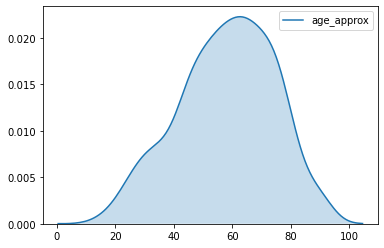

In [7]:
sns.kdeplot(dftrain[(dftrain['target'] == 1)].age_approx, shade = True)

#### Below plot is the distribution of sex of those affected

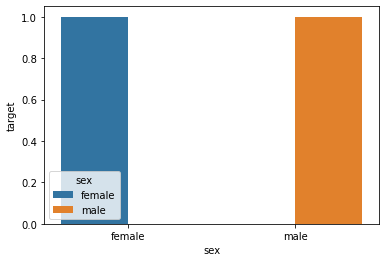

In [8]:
dummy = dftrain[dftrain['target'] == 1]

sns.barplot(x = "sex", y = "target", data = dummy, hue ="sex")



#### Comparision of affected (0 - blue) to unaffected (1 - orange)

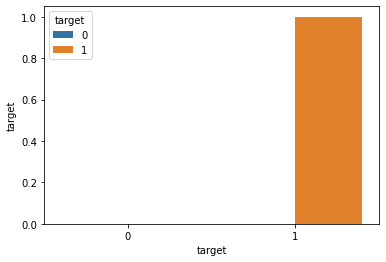

In [9]:
# viewing the distributions of data 

sns.barplot(x = "target", y = "target", data = dftrain, hue ="target")

## hence the number of unaffected surpasses the affected, we need to normalise this data. But we need to understand 
# various other columns before normalising this data

### lets see the distributions of sex  in  unaffected before removing normalizing

In [10]:
print("no of unaffected males  : ", len(dftrain[(dftrain['target'] == 0) & (dftrain['sex'] == 'male')]))
print("no of unaffected females  : ", len(dftrain[(dftrain['target'] == 0) & (dftrain['sex'] == 'female')]))

## not. much of a difference in. the ratios

no of unaffected males  :  16430
no of unaffected females  :  15526


#### Below chart is the distribution of anatom site challenge

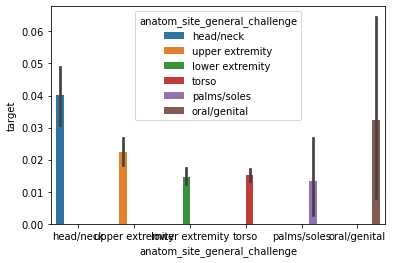

In [11]:
sns.barplot(x = "anatom_site_general_challenge", y = "target", data = dftrain, hue ="anatom_site_general_challenge")


In [12]:
## looking at the unique values of anatom_site_general_challenge column

dftrain.anatom_site_general_challenge.unique()

array(['head/neck', 'upper extremity', 'lower extremity', 'torso',
       'palms/soles', 'oral/genital'], dtype=object)

In [13]:
# looking at the number of unique values of anatom_site_general_challenge column

df = dftrain.copy()
print("no of head/neck  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'head/neck')]))
print("no of upper extremity  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'upper extremity')]))
print("no of lower extremity  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'lower extremity')]))
print("no of torso  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'torso')]))
print("no of palms/soles'  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'palms/soles')]))
print("no of oral/genital'  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'oral/genital')]))

no of head/neck  :  1771
no of upper extremity  :  4852
no of lower extremity  :  8275
no of torso  :  16568
no of palms/soles'  :  370
no of oral/genital'  :  120


In [14]:
## number of affected in the whole dataset

print("no of affected : ", len(dftrain[dftrain['target'] == 1]))

no of affected :  575


In [15]:
temp = dftrain[dftrain['target'] == 1]

## for training  (500 samples)
final_df = temp[:500]

## for testing (75 samples)
affected_validationdata = temp[500:]

#### selecting few samples randomly from the unaffected to normalize  the data

In [16]:
def random_data_selector(data, n):
    data =  data.sample(n = n)
    return data


df = dftrain.copy()

## selecting samples for testing (100 samples)
temp  = df[df['target'] == 0]
unaffected_validationdata = temp[:100]


data = random_data_selector(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'head/neck')], 100)
final_df = final_df.append(data, ignore_index = True)

data = random_data_selector(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'upper extremity')], 100)
final_df = final_df.append(data, ignore_index = True)

data = random_data_selector(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'lower extremity')], 100)
final_df = final_df.append(data, ignore_index = True)

data = random_data_selector(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'torso')], 100)
final_df = final_df.append(data, ignore_index = True)

data = random_data_selector(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'palms/soles')], 100)
final_df = final_df.append(data, ignore_index = True)

data = random_data_selector(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'oral/genital')], 100)
final_df = final_df.append(data, ignore_index = True)



In [17]:
final_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
1,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
2,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
3,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
4,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1


In [18]:
## finding the number of infected
len(final_df[final_df['target'] == 1])

500

In [19]:
## finding the number of infected
len(final_df[final_df['target'] == 0])

600

In [20]:
## shuffle the dataset

import sklearn

final_df  = sklearn.utils.shuffle(final_df)

In [21]:
import cv2
import pathlib
import imageio
from skimage.transform import resize
import numpy as np
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions



#converting normal images into numpy array


training_paths = pathlib.Path('../input/siim-isic-melanoma-classification/jpeg').glob('train/*.jpg')
training_sorted = sorted([x for x in training_paths])
directory_path = '../input/siim-isic-melanoma-classification/jpeg/train/'



for index in range(len(training_sorted)) : training_sorted[index] = str(training_sorted[index])    
    
training_images = np.zeros(150528)
training_images = training_images.reshape(1,224,224,3)

for index in range(len(final_df)):
    img_name = final_df.loc[index].image_name
    img_name = str(directory_path +  img_name + '.jpg')
    position_in_list = training_sorted.index(img_name)
    img_path = training_sorted[position_in_list]
    
    img = image.load_img(img_path, target_size = (224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)    
    training_images = np.vstack((training_images, x))
        
    print(index)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [22]:
training_images

array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+0

In [23]:
## making the xtrain data ready

xtraindf = training_images.copy()
xtraindf = xtraindf[1:]
xtraindf.shape
xtraindf

array([[[[ 1.20609970e+01, -3.77899933e+00,  4.43199997e+01],
         [ 1.10609970e+01, -2.77899933e+00,  4.03199997e+01],
         [ 1.10609970e+01, -1.77899933e+00,  4.53199997e+01],
         ...,
         [ 2.70609970e+01,  1.02210007e+01,  5.23199997e+01],
         [ 3.06099701e+00, -5.77899933e+00,  4.03199997e+01],
         [ 1.10609970e+01,  2.22100067e+00,  4.33199997e+01]],

        [[ 1.20609970e+01, -5.77899933e+00,  4.23199997e+01],
         [ 1.40609970e+01, -3.77899933e+00,  4.43199997e+01],
         [ 1.20609970e+01,  2.21000671e-01,  4.43199997e+01],
         ...,
         [ 2.00609970e+01,  1.22100067e+00,  4.93199997e+01],
         [ 5.06099701e+00, -6.77899933e+00,  4.23199997e+01],
         [ 1.80609970e+01,  5.22100067e+00,  4.63199997e+01]],

        [[ 8.06099701e+00, -8.77899933e+00,  3.63199997e+01],
         [ 2.10609970e+01,  2.22100067e+00,  4.83199997e+01],
         [ 1.10609970e+01, -2.77899933e+00,  4.63199997e+01],
         ...,
         [ 2.10609970e+0

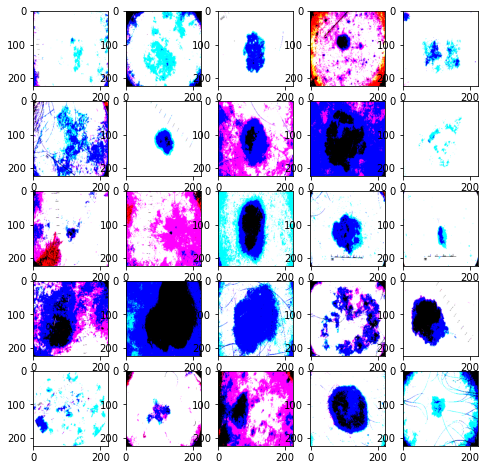

In [24]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    ax.imshow(xtraindf[i])

In [25]:
## making the ytrain data ready

ytraindf = final_df.target
ytraindf.head()

300    1
142    1
278    1
152    1
958    0
Name: target, dtype: int64

### Test data analysis

In [26]:
affected_validationdata = affected_validationdata.append(unaffected_validationdata)
testdata_copy = affected_validationdata.copy()

In [27]:
testdata_copy.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
28289,ISIC_8564474,IP_6649505,male,75.0,torso,melanoma,malignant,1
28296,ISIC_8566006,IP_6624700,male,65.0,torso,melanoma,malignant,1
28446,ISIC_8609756,IP_1264754,female,65.0,lower extremity,melanoma,malignant,1
28463,ISIC_8615491,IP_5278162,male,60.0,head/neck,melanoma,malignant,1
28467,ISIC_8617277,IP_3281766,female,40.0,torso,melanoma,malignant,1


In [28]:
print("affected : ", len(testdata_copy[testdata_copy['target'] == 1]))
print("unaffected : ", len(testdata_copy[testdata_copy['target'] == 0]))

affected :  75
unaffected :  100


In [29]:
## shuffle the df 
import sklearn

testdata_copy  = sklearn.utils.shuffle(testdata_copy).reset_index(drop=True)

In [30]:
testdata_copy.tail()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
170,ISIC_0148751,IP_5629228,female,40.0,upper extremity,unknown,benign,0
171,ISIC_0084270,IP_2961528,male,40.0,lower extremity,nevus,benign,0
172,ISIC_8564474,IP_6649505,male,75.0,torso,melanoma,malignant,1
173,ISIC_0077472,IP_3691360,female,40.0,torso,unknown,benign,0
174,ISIC_8922893,IP_9455054,male,50.0,upper extremity,melanoma,malignant,1


#### convert test images to numpy arrays

In [31]:


#converting normal images into numpy array


test_paths = pathlib.Path('../input/siim-isic-melanoma-classification/jpeg/').glob('train/*.jpg')
test_sorted = sorted([x for x in test_paths])
directory_path = '../input/siim-isic-melanoma-classification/jpeg/train/'



for index in range(len(test_sorted)) : test_sorted[index] = str(test_sorted[index])    
    
test_images = np.zeros(150528)
test_images = test_images.reshape(1,224,224,3)

for index in range(len(testdata_copy)):
    img_name = testdata_copy.loc[index].image_name
    img_name = str(directory_path +  img_name + '.jpg')
    
    position_in_list = test_sorted.index(img_name)
    img_path = test_sorted[position_in_list]
    
    img = image.load_img(img_path, target_size = (224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)    
    test_images = np.vstack((test_images, x))
        
    print(index)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


In [32]:
## Making the xtest data ready

xtestdf = test_images.copy()
xtestdf = xtestdf[1:]
xtestdf.shape
xtestdf

array([[[[ 5.06099701e+00, -3.77789993e+01, -6.16800003e+01],
         [ 1.10609970e+01, -2.37789993e+01, -4.86800003e+01],
         [ 2.90609970e+01, -1.17789993e+01, -4.26800003e+01],
         ...,
         [-8.09390030e+01, -9.57789993e+01, -1.02680000e+02],
         [-7.89390030e+01, -9.37789993e+01, -1.00680000e+02],
         [-8.49390030e+01, -9.97789993e+01, -1.06680000e+02]],

        [[ 3.06099701e+00, -3.37789993e+01, -6.06800003e+01],
         [ 1.70609970e+01, -2.17789993e+01, -4.26800003e+01],
         [ 2.20609970e+01, -1.17789993e+01, -3.96800003e+01],
         ...,
         [-7.69390030e+01, -9.17789993e+01, -9.96800003e+01],
         [-7.39390030e+01, -8.87789993e+01, -9.56800003e+01],
         [-8.19390030e+01, -9.67789993e+01, -1.03680000e+02]],

        [[-1.93900299e+00, -4.07789993e+01, -6.16800003e+01],
         [ 1.30609970e+01, -2.67789993e+01, -5.36800003e+01],
         [-7.93900299e+00, -4.57789993e+01, -6.26800003e+01],
         ...,
         [-7.69390030e+0

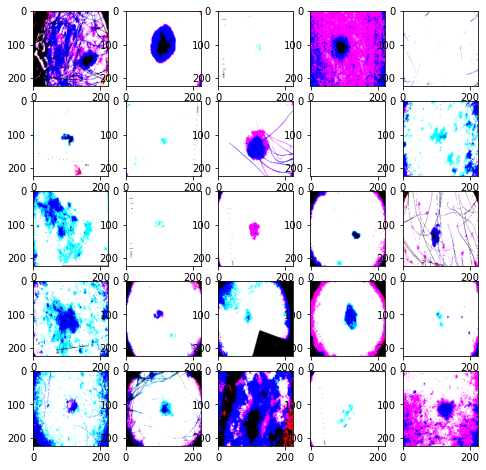

In [33]:
## plotting the images

import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    ax.imshow(xtestdf[i])

In [34]:
## making the ytest data ready

ytestdf = testdata_copy.target
ytestdf.head()

0    1
1    0
2    0
3    0
4    0
Name: target, dtype: int64

# ResNet50 model


In [76]:
from keras.applications.resnet50 import ResNet50

img_rows, img_cols = 224, 224


resnet = ResNet50(weights = 'imagenet',
                      include_top = False,
                      input_shape  =  (img_rows,  img_cols, 3))

## lets freeze the last  4 layers as they  are set to be trainable by  default
for layer in  resnet.layers:
  layer.trainable = False

## lets look at our layers
for (i, layer) in enumerate(resnet.layers):
  print(str(i)  + " "  +  layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Conv2D False
46 Conv2D False
47 BatchNormalization False
48 BatchNor

In [77]:

## Let us  create a function to build our top layer

def addTopMobileNetLayer(bottom_model, num_classes):

  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = (Dense(2048, activation = 'relu'))(top_model)
  top_model = (Dense(2048, activation = 'relu'))(top_model)
  top_model = (Dense(1024, activation = 'relu'))(top_model)
  top_model = (Dense(num_classes, activation  = 'softmax'))(top_model)

  return top_model

In [78]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation,  Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 2

FC_head = addTopMobileNetLayer(resnet, num_classes)

model  = Model(inputs =  resnet.input, outputs = FC_head)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

conv4_block5_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block5_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_add (Add)          (None, 14, 14, 1024) 0           conv4_block4_out[0][0]           
                                                                 conv4_block5_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_out (Activation)   (None, 14, 14, 1024) 0           conv4_block5_add[0][0]           
__________________________________________________________________________________________________
conv4_block6_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block5_out[0][0]           
__________________________________________________________________________________________________
conv4_block6_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block6_1_conv[0][0]        
__________

In [81]:

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop]


model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 0.009), metrics = ['accuracy'])

In [82]:
epochs = 10


history = model.fit(xtraindf, 
          ytraindf,
          batch_size = 16,
          epochs = epochs,
          verbose = 1,
          callbacks = callbacks,
          validation_data = (xtestdf, ytestdf)
          )

Epoch 1/10
69/69 [==============================] - 103s 1s/step - loss: 7.6646 - accuracy: 0.5455 - val_loss: 7.6623 - val_accuracy: 0.5714
Epoch 2/10
69/69 [==============================] - 110s 2s/step - loss: 7.6646 - accuracy: 0.5455 - val_loss: 7.6623 - val_accuracy: 0.5714
Epoch 3/10
69/69 [==============================] - 100s 1s/step - loss: 7.6646 - accuracy: 0.5455 - val_loss: 7.6623 - val_accuracy: 0.5714
Epoch 4/10
69/69 [==============================] - 101s 1s/step - loss: 7.6646 - accuracy: 0.5455 - val_loss: 7.6623 - val_accuracy: 0.5714
Epoch 00004: early stopping


### My CNN

In [87]:

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard

In [120]:
model = Sequential()
model.add(Conv2D(24,3,3, input_shape = (224,224,3), activation = 'relu'))
model.add(Conv2D(36,3,3, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(36,3,3, activation = 'relu'))
model.add(Conv2D(36,3,3,  activation = 'relu'))

model.add(Flatten())
model.add(Dense(units = 2028, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [121]:
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.005), metrics = ['accuracy'])
epochs = 10


history = model.fit(xtraindf, 
          ytraindf,
          batch_size = 64,
          epochs = epochs,
          verbose = 1,
          validation_data = (xtestdf, ytestdf))

Epoch 1/10
18/18 [==============================] - 3s 163ms/step - loss: 104.3361 - accuracy: 0.5100 - val_loss: 0.6415 - val_accuracy: 0.5771
Epoch 2/10
18/18 [==============================] - 3s 174ms/step - loss: 0.6919 - accuracy: 0.5427 - val_loss: 0.6876 - val_accuracy: 0.5486
Epoch 3/10
18/18 [==============================] - 3s 172ms/step - loss: 0.6930 - accuracy: 0.5382 - val_loss: 0.6724 - val_accuracy: 0.5657
Epoch 4/10
18/18 [==============================] - 3s 157ms/step - loss: 0.6973 - accuracy: 0.5364 - val_loss: 0.6958 - val_accuracy: 0.5543
Epoch 5/10
18/18 [==============================] - 3s 154ms/step - loss: 0.6911 - accuracy: 0.5582 - val_loss: 0.7021 - val_accuracy: 0.4229
Epoch 6/10
18/18 [==============================] - 3s 153ms/step - loss: 0.7430 - accuracy: 0.5091 - val_loss: 0.8298 - val_accuracy: 0.5714
Epoch 7/10
18/18 [==============================] - 3s 155ms/step - loss: 0.7840 - accuracy: 0.5127 - val_loss: 0.6897 - val_accuracy: 0.5771
Epoc

Text(0.5, 0, 'Epoch')

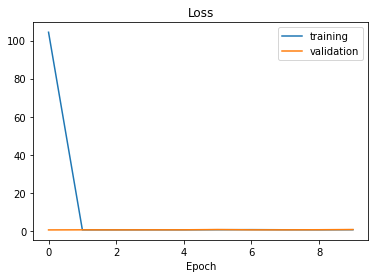

In [123]:
#plot of validation vs training accuracy over the epochs

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [124]:
ypred = model.predict(xtestdf)
evaluation = model.evaluate(xtestdf, ytestdf)
print('Test accuracy : {:.3f}'.format(evaluation[1]))

6/6 [==============================] - 0s 18ms/step - loss: 0.8404 - accuracy: 0.6400
Test accuracy : 0.640
